# Libraries Installation

In [1]:
library(leaps)
library(glmnet)
library(caret)
library(caTools)
library(boot)
library(MASS)
library(ISLR)
library(car)
library(mltools)
library(readxl)
library(dplyr)

Loading required package: Matrix

Loaded glmnet 3.0-1


Loading required package: lattice

Loading required package: ggplot2


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘boot’


The following object is masked from ‘package:lattice’:

    melanoma


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:boot’:

    logit



Attaching package: ‘dplyr’


The following object is masked from ‘package:car’:

    recode


The following object is masked from ‘package:MASS’:

    select


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




# Reading Data

In [2]:
train = read_excel("../input/houseprice/case_study_ridge_lasso.xls")
test = read_excel("../input/houseprice/case_study_ridge_lasso.xls", sheet = 2)

Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in BJ1118 / R1118C62: got 'NA'”
Warning message in read_fun(path = enc2native(normalizePath(path)), sheet_i = sheet, :
“Expecting numeric in BK1118 / R1118C63: got 'NA'”


# Combining Train and Test for Preprocessing

In [3]:
SalePrice = 0
test = cbind(test, SalePrice)
combi = rbind(train, test)

sum(is.na(combi))

[1] 2

In [4]:
str(combi)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	2919 obs. of  81 variables:
 $ Id           : num  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : num  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : chr  "RL" "RL" "RL" "RL" ...
 $ LotFrontage  : chr  "65" "80" "68" "60" ...
 $ LotArea      : num  8450 9600 11250 9550 14260 ...
 $ Street       : chr  "Pave" "Pave" "Pave" "Pave" ...
 $ Alley        : chr  "NA" "NA" "NA" "NA" ...
 $ LotShape     : chr  "Reg" "Reg" "IR1" "IR1" ...
 $ LandContour  : chr  "Lvl" "Lvl" "Lvl" "Lvl" ...
 $ Utilities    : chr  "AllPub" "AllPub" "AllPub" "AllPub" ...
 $ LotConfig    : chr  "Inside" "FR2" "Inside" "Corner" ...
 $ LandSlope    : chr  "Gtl" "Gtl" "Gtl" "Gtl" ...
 $ Neighborhood : chr  "CollgCr" "Veenker" "CollgCr" "Crawfor" ...
 $ Condition1   : chr  "Norm" "Feedr" "Norm" "Norm" ...
 $ Condition2   : chr  "Norm" "Norm" "Norm" "Norm" ...
 $ BldgType     : chr  "1Fam" "1Fam" "1Fam" "1Fam" ...
 $ HouseStyle   : chr  "2Story" "1Story" "2Story" "2Story" ...
 $

# Data Preprocessing

In [5]:
combi = combi %>% mutate(LotFrontage=replace(LotFrontage, LotFrontage=="NA",NA))
combi$LotFrontage = as.numeric(combi$LotFrontage)
combi = combi %>% 
  mutate(LotFrontage=replace(LotFrontage, 
                             is.na(LotFrontage),
                             round(mean(LotFrontage, na.rm = T),2)))

In [6]:
combi = combi %>% mutate(MasVnrArea=replace(MasVnrArea, MasVnrArea=="NA", NA))
combi$MasVnrArea = as.numeric(combi$MasVnrArea)
combi = combi %>% mutate(MasVnrArea=replace(MasVnrArea, is.na(MasVnrArea),round(mean(MasVnrArea, na.rm = T),2)))

In [7]:
combi = combi %>% mutate(GarageCars=replace(GarageCars, is.na(GarageCars),round(mean(GarageCars, na.rm = T),2)))
combi = combi %>% mutate(GarageArea=replace(GarageArea, is.na(GarageArea),round(mean(GarageArea, na.rm = T),2)))

In [8]:
combi$BsmtFinSF1 = as.numeric(combi$BsmtFinSF1)
combi = combi %>% mutate(BsmtFinSF1=replace(BsmtFinSF1, is.na(BsmtFinSF1),round(mean(BsmtFinSF1, na.rm = T),2)))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [9]:
combi$BsmtFinSF2 = as.numeric(combi$BsmtFinSF2)
combi = combi %>% mutate(BsmtFinSF2=replace(BsmtFinSF2, is.na(BsmtFinSF2),round(mean(BsmtFinSF2, na.rm = T),2)))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [10]:
combi$TotalBsmtSF = as.numeric(combi$TotalBsmtSF)
combi = combi %>% 
  mutate(TotalBsmtSF=replace(TotalBsmtSF, 
                             is.na(TotalBsmtSF),
                             round(mean(TotalBsmtSF, na.rm = T),2)))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [11]:
combi$BsmtUnfSF = as.numeric(combi$BsmtUnfSF)
combi = combi %>% mutate(BsmtUnfSF=replace(BsmtUnfSF, is.na(BsmtUnfSF),round(mean(BsmtUnfSF, na.rm = T),2)))

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [12]:
summary(factor(combi$MasVnrType))
combi = combi %>% mutate(MasVnrType=replace(MasVnrType, MasVnrType=="NA","None"))
summary(factor(combi$MasVnrType))

BrkCmn BrkFace      NA    None   Stone 
     25     879      24    1742     249

BrkCmn BrkFace    None   Stone 
     25     879    1766     249

In [13]:
combi = combi %>% mutate(GarageYrBlt=replace(GarageYrBlt, GarageYrBlt=="NA",NA))

index = which(is.na(combi$GarageYrBlt))
combi[index,'GarageYrBlt'] = combi[index,'YearBuilt']
combi$GarageYrBlt = as.numeric(combi$GarageYrBlt)

In [14]:
combi$ExterQual = ordered(combi$ExterQual)
combi$ExterCond = ordered(combi$ExterCond)
combi$BsmtQual = ordered(combi$BsmtQual)
combi$BsmtCond = ordered(combi$BsmtCond)
combi$HeatingQC = ordered(combi$HeatingQC)
combi$KitchenQual = ordered(combi$KitchenQual)
combi$FireplaceQu = ordered(combi$FireplaceQu)
combi$GarageQual = ordered(combi$GarageQual)
combi$GarageCond = ordered(combi$GarageCond)
combi$PoolQC = ordered(combi$PoolQC)

In [15]:
combi = as.data.frame(unclass(combi))

In [16]:
str(combi)

'data.frame':	2919 obs. of  81 variables:
 $ Id           : num  1 2 3 4 5 6 7 8 9 10 ...
 $ MSSubClass   : num  60 20 60 70 60 50 20 60 50 190 ...
 $ MSZoning     : Factor w/ 6 levels "C (all)","FV",..: 5 5 5 5 5 5 5 5 6 5 ...
 $ LotFrontage  : num  65 80 68 60 84 ...
 $ LotArea      : num  8450 9600 11250 9550 14260 ...
 $ Street       : Factor w/ 2 levels "Grvl","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ Alley        : Factor w/ 3 levels "Grvl","NA","Pave": 2 2 2 2 2 2 2 2 2 2 ...
 $ LotShape     : Factor w/ 4 levels "IR1","IR2","IR3",..: 4 4 1 1 1 1 4 1 4 4 ...
 $ LandContour  : Factor w/ 4 levels "Bnk","HLS","Low",..: 4 4 4 4 4 4 4 4 4 4 ...
 $ Utilities    : Factor w/ 3 levels "AllPub","NA",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ LotConfig    : Factor w/ 5 levels "Corner","CulDSac",..: 5 3 5 1 3 5 5 1 5 1 ...
 $ LandSlope    : Factor w/ 3 levels "Gtl","Mod","Sev": 1 1 1 1 1 1 1 1 1 1 ...
 $ Neighborhood : Factor w/ 25 levels "Blmngtn","Blueste",..: 6 25 6 7 14 12 21 17 18 4 ...
 $ Condition1   : 

In [17]:
sum(is.na(combi))

[1] 0

# Seperating Train and Test data after preprocessing

In [18]:
train_ = combi[1:nrow(train),]
test_ = combi[(nrow(train) + 1):nrow(combi),]

# Splitting train data into train validation set

In [19]:
set.seed(123)
split = sample.split(train_$SalePrice, SplitRatio = 0.8)
training_set = subset(train_, split==TRUE)
validation_set = subset(train_, split==FALSE)

In [20]:
X = model.matrix(SalePrice ~.-Id, data=training_set)[,-1]
X_val = model.matrix(SalePrice ~.-Id, data=validation_set)[,-1]
y = training_set$SalePrice

# User Defined Lambda for Lasso
ld = 10^seq(10, -2, length=100)

# Applying Lasso Regression

Warning message in regularize.values(x, y, ties, missing(ties)):
“collapsing to unique 'x' values”


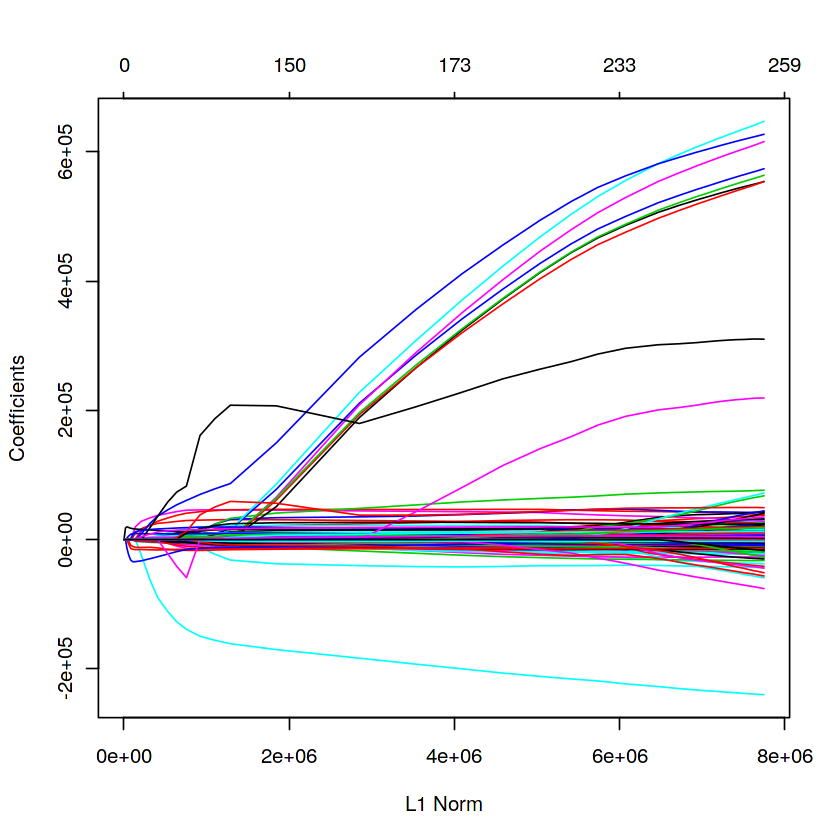

In [21]:
rig.fit = glmnet(X, y, alpha=1, lambda=ld)
plot(rig.fit)

# Cross Validating train data with 5-folds

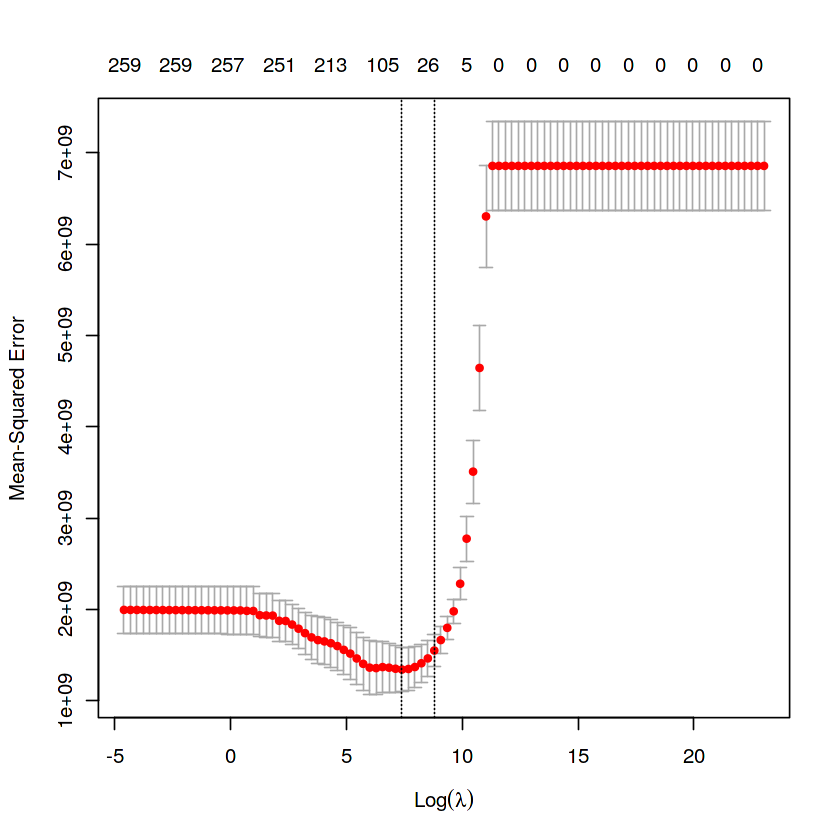

In [22]:
cvglm = cv.glmnet(X, y, alpha=1, lambda=ld, nfolds=5)
plot(cvglm)

# Best Lambda to choose for more optimized model

In [23]:
best = cvglm$lambda.min
best

[1] 1629.751

# Variables to consider after applying lasso

In [24]:
predict(rig.fit, s=best, type='coefficients')

273 x 1 sparse Matrix of class "dgCMatrix"
                                 1
(Intercept)          -3.491787e+05
MSSubClass           -1.478774e+02
MSZoningFV            .           
MSZoningNA            .           
MSZoningRH            .           
MSZoningRL            .           
MSZoningRM           -4.293355e+03
LotFrontage           .           
LotArea               2.752284e-01
StreetPave            .           
AlleyNA               .           
AlleyPave             .           
LotShapeIR2           6.660246e+02
LotShapeIR3          -1.007013e+04
LotShapeReg           .           
LandContourHLS        .           
LandContourLow        .           
LandContourLvl        .           
UtilitiesNA           .           
UtilitiesNoSeWa       .           
LotConfigCulDSac      7.638706e+03
LotConfigFR2          .           
LotConfigFR3          .           
LotConfigInside       .           
LandSlopeMod          .           
LandSlopeSev          .           
Neighborhood

    . represents that variable are tending toward zero and hence it can be neglected

# Validating Validation Set and calculating RMSLE

In [25]:
pred_rl = predict(rig.fit, s=best, newx = X_val)
sqrt(mean((log(validation_set$SalePrice) - log(pred_rl))^2))

[1] 0.1283297

# Predicting Test Set for submission

In [26]:
row.names(test_) = NULL
test_set = model.matrix(SalePrice ~.-Id, data=test_)[,-1]
pred_test = predict(rig.fit, s=best, newx = test_set)

In [27]:
df = as.data.frame(cbind(test_$Id, pred_test))

names(df)[1] = 'Id'
names(df)[2] = 'SalePrice'

write.csv(df, "submission.csv", row.names = F)